In [132]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.saving import save_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [133]:
df = pd.read_csv('model_data_1min.csv')
df.head()

,Unnamed: 0,trade_id,product_id,price,size,time,side,bid,ask,exchange,...,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,60305,590641283,ETH-USD,3598.16,0.013755,2025-01-04 06:38:20.767435+00:00,SELL,NaN,NaN,NaN,...,36308.0,36308.0,36308.0,36308.0,36308.0,36308.0,227275.0,227275.0,143784.0,60293.0
1,60304,590641310,ETH-USD,3598.95,0.002479,2025-01-04 06:38:35.543964+00:00,SELL,NaN,NaN,NaN,...,36309.0,36309.0,36309.0,36309.0,36309.0,36309.0,227274.0,227274.0,143783.0,60292.0
2,60303,590641344,ETH-USD,3598.15,3.565571,2025-01-04 06:38:55.779501+00:00,BUY,NaN,NaN,NaN,...,36310.0,36310.0,36310.0,36310.0,36310.0,36310.0,227273.0,227273.0,143782.0,60291.0
3,60302,590641361,ETH-USD,3597.71,0.000987,2025-01-04 06:39:14.353069+00:00,BUY,NaN,NaN,NaN,...,36311.0,36311.0,36311.0,36311.0,36311.0,36311.0,227272.0,227272.0,143781.0,60290.0
4,60301,590641382,ETH-USD,3597.72,0.200000,2025-01-04 06:39:29.902680+00:00,SELL,NaN,NaN,NaN,...,36312.0,36312.0,36312.0,36312.0,36312.0,36312.0,227271.0,227271.0,143780.0,60289.0


In [134]:
#data set is one datapoint every 15 seconds. Want to look once every 3 minutes instead. So we're going to limit our dataset as such
# Make sure 'time' is a datetime object
df['time'] = pd.to_datetime(df['time'])

# Set it as index
df.set_index('time', inplace=True)

# Resample every 6 minutes
minute = 12
df_resampled = df.resample(f'{minute}T').agg({
    'price': 'last',  # Last traded price in the interval
    'size': 'sum',    # Total volume traded in the interval
    'side': lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'  # Most common side or fallback
})

#x = 4000 #start data a 3/1

# Grab everything after (and including) the 83,000th row
#df_resampled = df_resampled.iloc[x:]

df_resampled = df_resampled.reset_index()
df_resampled.head()
df_resampled.to_csv('resampled_data.csv')

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_23182/991056651.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(f'{minute}T').agg({


In [135]:
df_resampled.head()

,time,price,size,side
0,2025-01-04 06:36:00+00:00,3594.34,6.551917,SELL
1,2025-01-04 06:48:00+00:00,3598.94,2.166045,SELL
2,2025-01-04 07:00:00+00:00,3604.52,6.454355,SELL
3,2025-01-04 07:12:00+00:00,3599.73,15.299945,SELL
4,2025-01-04 07:24:00+00:00,3601.35,9.520276,SELL


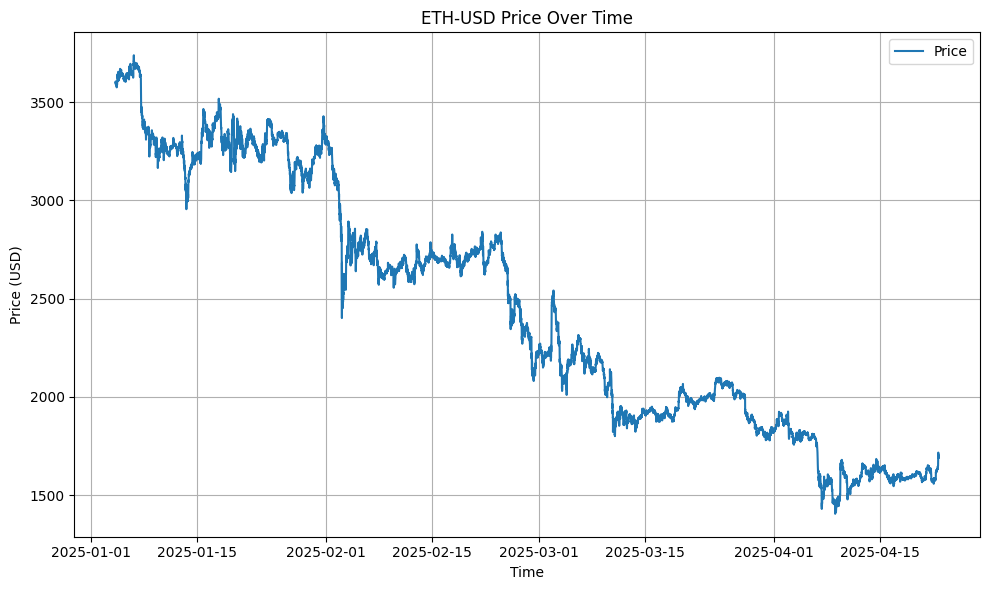

In [136]:
df_trades = df_resampled

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [137]:
# Ensure time column is sorted
df_trades = df_trades.sort_values('time')

# Scale the 'price' and 'size' column
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5     # Predict 5 steps into the future

In [138]:
# Compute percent   difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage

# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_23182/1791461416.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage


In [139]:

def compute_technical_indicators(df):
    close = df['price_scaled']
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['EMA'] = close.ewm(span=14, adjust=False).mean()
    df['SMA'] = close.rolling(window=14).mean()
    return df

df_indicators = compute_technical_indicators(df_trades.copy())
df_indicators.dropna(inplace=True)

In [140]:

X = []
y = []
prices = df_trades['price_scaled'].values

for i in range(len(df_indicators) - 3):
    sequence = [df_indicators.iloc[i]['RSI'],
                df_indicators.iloc[i+1]['EMA'],
                df_indicators.iloc[i+2]['SMA']]
    target = prices[i+3]
    X.append(sequence)
    y.append(target)

X = np.array(X).reshape(-1, 3, 1)
y = np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)


Input shape: (12981, 3, 1)
Output shape: (12981,)


In [141]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(3,1)),
    LSTM(50),
    Dense(1)
])

model.summary()

# Filter out NaN samples
mask = ~np.isnan(X).any(axis=(1,2)) & ~np.isnan(y)
X = X[mask]
y = y[mask]
model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Filter out NaN samples
mask = ~np.isnan(X).any(axis=(1,2)) & ~np.isnan(y)
X = X[mask]
y = y[mask]

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape

(10384, 3, 1)

In [143]:
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1699 - val_loss: 0.1551
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0426 - val_loss: 0.0756
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0177 - val_loss: 0.0067
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0967e-04 - val_loss: 0.0015
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9157e-04 - val_loss: 0.0013
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1896e-04 - val_loss: 0.0011
Epoch 8/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8457e-04 - val_loss: 9.7263e-04
Epoch 9/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6708e-04 - val_loss: 9.1231e-04
Epoch 10/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5932e-04 - val_loss: 7.8259e-04
Epoch 11/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0723e-04 - val_loss: 6.5939e-

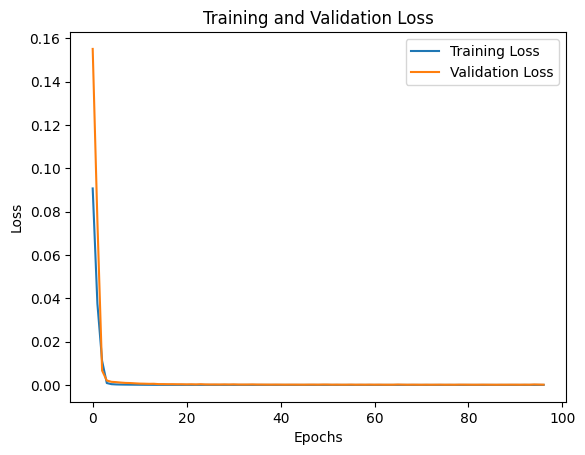

In [144]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [145]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and test labels to get original prices
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [146]:
def print_percent_diff(A, B):
    # Compute % difference for each element
    percent_diff = np.abs(A - B) / ((A + B) / 2) * 100

    # Compute and print the average percentage difference
    average_percent_diff = np.mean(percent_diff)
    print("Average Percentage Difference:", average_percent_diff)

In [147]:
print_percent_diff(y_test_original, predictions)

Average Percentage Difference: 1.0775279159976179


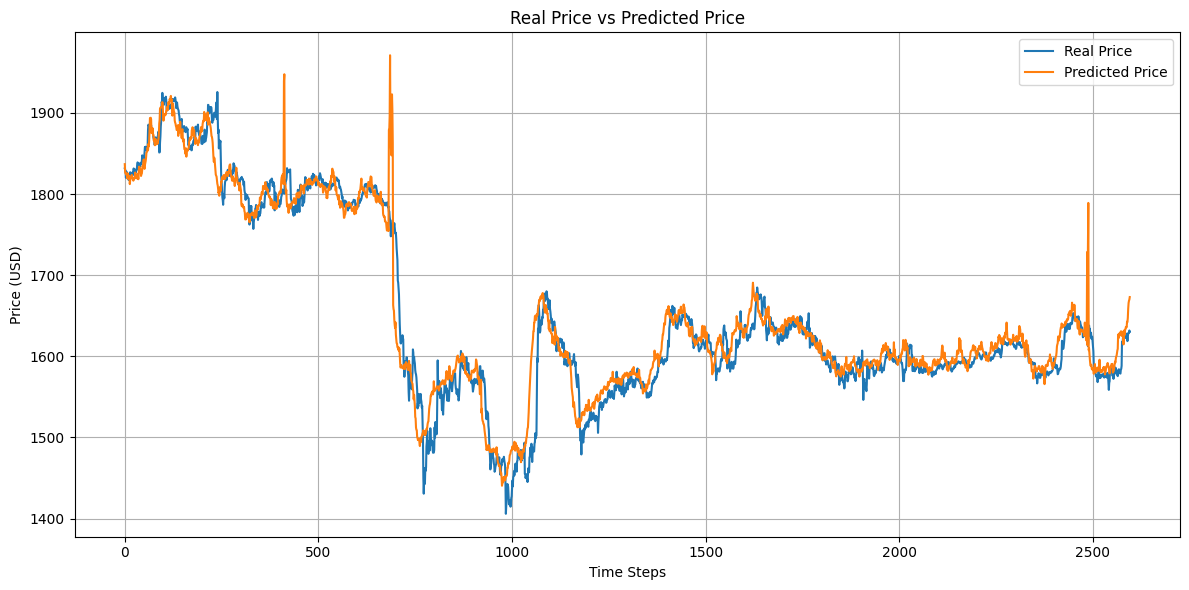

In [148]:
# Plot the real vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Real Price", linestyle='-')
plt.plot(predictions, label="Predicted Price", linestyle='-')
plt.title("Real Price vs Predicted Price")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [149]:
print(f"--------Model Information--------\r\nInterval: {minute * 60} seconds\r\nsequence_length: {sequence_length}\r\nforecast_steps: {forecast_steps}")

--------Model Information--------
Interval: 720 seconds
sequence_length: 10
forecast_steps: 5
